### 문제 6-1 : 조건부 분기가 있는 메뉴 추천 시스템 ( LangGraph 사용하기)<br>
MessagesState를 사용하여 고객의 카페 관련 문의에 자동으로 응답하는 시스템을 만드세요. 고객이 메뉴, 가격, 추천 등에 대해 질문하면 카페 메뉴 데이터를 바탕으로 적절한 답변을 생성하는 시스템을 구현하세요.<br>

#### 학습 목표<br>
* 의미론적 검색: 사용자 문의를 직접 검색어로 활용하는 방법<br>
* MessagesState + Vector DB: 대화형 시스템과 벡터 검색 결합<br>
* 동적 정보 추출: 검색된 문서에서 구조화된 정보 추출<br>
* 실시간 검색 응답: 사용자 문의에 맞춤형 실시간 검색 결과 제공

#### 핵심 개념 설명<br>
* MessagesState: 메시지 리스트를 자동으로 관리하는 LangGraph의 특별한 상태 클래스<br>
* HumanMessage/AIMessage: 사용자와 AI의 메시지를 구분하는 LangChain의 메시지 클래스<br>
* 자연어 처리: 사용자의 텍스트 입력을 분석하여 의도를 파악하는 과정<br>
* 상태 확장: MessagesState를 상속받아 추가 필드를 포함하는 방법

#### 구현 단계별 가이드<br>
* 상태 정의: MessagesState를 상속받아 필요한 추가 필드 정의<br>
* 문의 분류 로직: 키워드 기반으로 사용자 문의 유형을 분류하는 함수 구현<br>
* 응답 생성 함수들: 각 문의 유형별로 적절한 응답을 생성하는 함수들 작성<br>
* 메시지 처리: 사용자의 마지막 메시지를 분석하고 적절한 응답 메시지 생성

#### 요구사항:<br>
* MessagesState 사용<br>
* 질문 유형 분류 (메뉴 문의, 가격 문의, 추천 요청)<br>
* 각 유형별 맞춤 응답 생성<br>
대화 이력 유지

### 환경 설정

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

### Messages State 정의

In [3]:
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document

class CafeState(MessagesState):
    documents: List[Document] = []
    query_type: str = ""

### RAG Chain 구성

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

embeddings_model = OllamaEmbeddings(model="bge-m3:latest") 

# cafe db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# LLM 모델 
llm = ChatOpenAI(
    base_url="https://api.groq.com/openai/v1",
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.7
)

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# prompt 정의
system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = cafe_db.as_retriever(
    search_kwargs={"k": 6}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "학생을 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

학생을 위한 메뉴를 추천해 드리겠습니다.

1.  **예산** 학생의 경우 경제적인 부담이 적어야 하므로, 가격대가 저렴한 메뉴를 추천해 드리겠습니다.
2.  **영양** 학생은 성장기에 있는 만큼, 영양소를 골고루 섭취하는 것이 중요합니다. 그러므로, 메뉴의 영양 정보도 고려하겠습니다.

위의 두 가지 요소를 고려하여 추천해 드리는 메뉴는 다음과 같습니다.

*   **아이스 아메리카노** - 가격: ₩4,500 - 주요 원료: 에스프레소, 차가운 물, 얼음 - 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다.

*   **카페라떼** - 가격: ₩5,500 - 주요 원료: 에스프레소, 스팀 밀크 - 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.

두 메뉴 모두 가격대가 저렴하고, 성장기 학생에게 필요한 영양소를 함유하고 있습니다. 또한, 두 메뉴는 모두 커피를 베이스로 한 음료로, 집중력을 높이고 피로를 풀어주는 효과가 있습니다.


### 노드(Node)

In [12]:
def classify_query(state: CafeState) -> Dict:
    user_message = state["messages"][-1].content

    if "추천" in user_message:
        query_type = "recommend"
    elif "가격" in user_message or "얼마" in user_message:
        query_type = "price"
    elif "메뉴" in user_message or "있어" in user_message:
        query_type = "menu"
    else:
        query_type = "general"

    return {"query_type": query_type}

In [13]:
from typing import Dict

def search_cafe_docs(state: CafeState) -> Dict:
    user_message = state["messages"][-1].content
    query_type = state.get("query_type", "general")

    # 기본값
    docs = []

    if query_type == "price":
        docs = cafe_db.similarity_search("메뉴 가격", k=5)

    elif query_type == "recommend":
        docs = cafe_db.similarity_search(user_message, k=3)
        if not docs:
            docs = cafe_db.similarity_search("인기 메뉴", k=3)

    elif query_type == "menu":
        docs = cafe_db.similarity_search(user_message, k=4)

    else:
        docs = cafe_db.similarity_search(user_message, k=4)

    return {"documents": docs}

In [14]:
import re
from langchain_core.documents import Document

def extract_menu_info(doc: Document) -> dict:
    content = doc.page_content
    menu_name = doc.metadata.get('menu_name', 'Unknown')
    
    price_match = re.search(r'₩([\d,]+)', content)
    description_match = re.search(r'설명:\s*(.+?)(?:\n|$)', content, re.DOTALL)

    return {
        "name": menu_name,
        "price": price_match.group(0) if price_match else "가격 정보 없음",
        "description": description_match.group(1).strip() if description_match else "설명 없음"
    }


In [15]:
from langchain_core.messages import AIMessage

def retrieve_and_respond(state: CafeState) -> Dict:
    user_message = state["messages"][-1].content

    # RAG 체인 실행
    response = rag_chain.invoke(user_message)

    # 메시지 추가
    new_messages = state["messages"] + [AIMessage(content=response)]

    return {
        "messages": new_messages
    }

In [38]:
from pydantic import BaseModel, Field

class GradeResponse(BaseModel):
    "A score for answers"
    score: float = Field(..., description="A score from 0 to 1, where 1 is perfect")
    explanation: str = Field(..., description="An explanation for the given score")

# 답변 품질 평가 함수
def grade_answer(state: CafeState):
    messages = state['messages']
    question = messages[-2].content
    answer = messages[-1].content
    context = format_docs(state['documents'])

    grading_system = """You are an expert grader. 
    Grade the following answer based on its relevance and accuracy to the question, considering the given context. 
    Provide a score from 0 to 1, where 1 is perfect, along with an explanation."""

    grading_prompt = ChatPromptTemplate.from_messages([
        ("system", grading_system),
        ("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])
    
    try:
        grading_chain = grading_prompt | llm.with_structured_output(schema=GradeResponse)
        grade_response = grading_chain.invoke({
            "question": question,
            "context": context,
            "answer": answer
        })
        
        score = max(0, min(1, grade_response.score))
        
    except Exception as e:
        print(f"Error during grading: {e}")
        score = 0.5
        grade_response = GradeResponse(score=score, explanation="Error occurred during grading")

    # 답변 생성 횟수를 증가 
    num_generation = state.get('num_generation', 0)
    num_generation += 1
    
    return {
        "messages": messages,
        "documents": state["documents"],
        "query_type": state.get("query_type", ""),
        "grade": score,
        "num_generation": state.get("num_generation", 0) + 1
    }

### 엣지(Edge)

In [39]:
from typing import Literal

def should_retry(state: CafeState) -> Literal["retrieve_and_respond", "generate"]:
    print("----GRADING---")
    print("Grade Score: ", state.get("grade"))

    if state.get("num_generation", 0) > 2:
        return "generate"
    
    if state.get("grade", 0.0) < 0.7:
        return "retrieve_and_respond"
    else:
        return "generate"


### 그래프(Graph) 구성

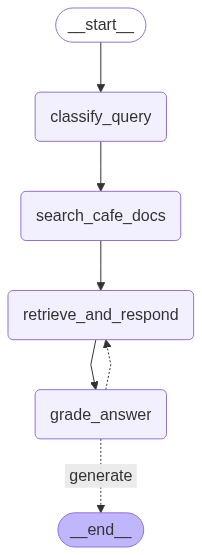

In [40]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 설정
builder = StateGraph(CafeState)

# 노드 추가
builder.add_node("classify_query", classify_query)
builder.add_node("search_cafe_docs", search_cafe_docs)
builder.add_node("retrieve_and_respond", retrieve_and_respond)
builder.add_node("grade_answer", grade_answer)

# 엣지 연결
builder.add_edge(START, "classify_query")
builder.add_edge("classify_query", "search_cafe_docs")
builder.add_edge("search_cafe_docs", "retrieve_and_respond")
builder.add_edge("retrieve_and_respond", "grade_answer")

# 조건 분기 연결
builder.add_conditional_edges(
    "grade_answer",
    should_retry,
    {
        "retrieve_and_respond": "retrieve_and_respond",
        "generate": END
    }
)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

### 그래프(Graph) 실행

In [41]:
from langchain_core.messages import HumanMessage
from pprint import pprint

initial_state = CafeState(
    messages=[HumanMessage(content="학생을 위한 메뉴를 추천해주세요.")],
    documents=[],
    query_type="",
    grade=0.0,
    num_generation=0
)

final_state = graph.invoke(initial_state)

# 출력
print("최종 상태:")
pprint(final_state)

print("응답 내용:")
for m in final_state["messages"]:
    print(f"{m.type.upper()}: {m.content}")

print(f"평가 점수: {final_state['grade']}")
print(f"생성 횟수: {final_state['num_generation']}")


----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None
----GRADING---
Grade Score:  None


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT